### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pwd

### Setup MLFlow

Create local aritfact store:
```bash
mkdir -p $(pwd)/../mlruns_artifacts
```

Using UI : 
```bash 
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

Using server : 
```bash
mlflow server \
--backend-store-uri sqlite:///mlflow.db \
--default-artifact-root file:///$(pwd)/../mlruns_artifacts 
``` 


In [3]:
import mlflow

# mlflow.set_tracking_uri("sqlite:///mlflow.db") # UI tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000") # server tracking

print(f"Tracking URI: '{mlflow.get_tracking_uri()}'")
mlflow.set_experiment("airbnb-experiment")
mlflow.autolog(disable=True)

2024/11/23 17:33:43 INFO mlflow.tracking.fluent: Experiment with name 'airbnb-experiment' does not exist. Creating a new experiment.


Tracking URI: 'http://127.0.0.1:5000'


In [4]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:////home/oliver/Desktop/Workspace/Projects/airbnb-price-prediciton/experiment-tracking/../mlruns_artifacts/1', creation_time=1732358023753, experiment_id='1', last_update_time=1732358023753, lifecycle_stage='active', name='airbnb-experiment', tags={}>,
 <Experiment: artifact_location='file:////home/oliver/Desktop/Workspace/Projects/airbnb-price-prediciton/experiment-tracking/../mlruns_artifacts/0', creation_time=1732357512457, experiment_id='0', last_update_time=1732357512457, lifecycle_stage='active', name='Default', tags={}>]

### Load Data

In [5]:
def read_dataframe(filename):
    df = pd.read_csv(filename)
    
    # Handle missing values
    df = df.dropna(subset=['price'])
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    df['last_review'] = pd.to_datetime(df['last_review'])
    
    # Apply a log10 transformation to the target column
    df['price'] = np.log10(df['price'])

    return df

In [6]:
def preprocess(df):
    # Calculate IQR
    Q1 = df['price'].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df['price'].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].reset_index(drop=True)
    
    return df

In [7]:
df_train = read_dataframe("../datasets/airbnb-listings-may.csv")
df_val = read_dataframe("../datasets/airbnb-listings-june.csv")

In [8]:
df_train = preprocess(df_train)
df_val = preprocess(df_val)

In [9]:
len(df_train), len(df_val)

(328, 357)

In [10]:
# Feature selection
numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
categorical = ['room_type', 'neighbourhood']

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

# dv = DictVectorizer()
# X_train = dv.fit_transform(train_dicts)
# X_val = dv.transform(val_dicts)

In [11]:
target = "price"
y_train = df_train[target].values
y_val = df_val[target].values

### LinearRegression

In [12]:
# Create a pipeline with DictVectorizer and LinearRegression
pipeline = Pipeline([
    ('dv', DictVectorizer()),
    ('lr', LinearRegression())
])

pipeline.fit(train_dicts, y_train)
y_pred = pipeline.predict(val_dicts)
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.16307290098131869


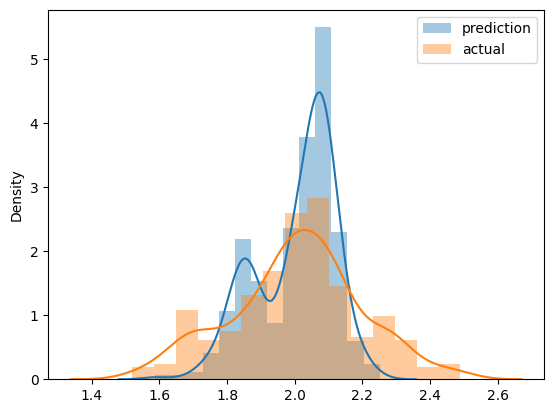

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()
plt.show()

In [14]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():

    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
    mlflow.log_param("model_name", "Linear Regression")  # Log model name
    
    pipeline = Pipeline([
        ('dv', DictVectorizer()),
        ('lr', LinearRegression())
    ])

    pipeline.fit(train_dicts, y_train)
    y_pred = pipeline.predict(val_dicts)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    # with open("../models/preprocessor.b", "wb") as f_out:
    #     pickle.dump(dv, f_out)
    # mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    with open("../models/lin_reg.bin", "wb") as f_out:
        pickle.dump(pipeline, f_out)
    mlflow.log_artifact(local_path="../models/lin_reg.bin", artifact_path="models")

🏃 View run spiffy-snake-463 at: http://127.0.0.1:5000/#/experiments/1/runs/e35b2d5b79294da9b8dcec0ca81b28be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### LASSO

In [15]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():

    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
    mlflow.log_param("model_name", "Lasso")  # Log model name
    
    params = {
        'alpha': 0.1,
    }
    mlflow.log_params(params)
    
    pipeline = Pipeline([
        ('dv', DictVectorizer()),
        ('lr', Lasso(**params))
    ])

    pipeline.fit(train_dicts, y_train)
    y_pred = pipeline.predict(val_dicts)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    # with open("../models/preprocessor.b", "wb") as f_out:
    #     pickle.dump(dv, f_out)
    # mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    with open("../models/lasso_reg.bin", "wb") as f_out:
        pickle.dump(pipeline, f_out)
    mlflow.log_artifact(local_path="../models/lasso_reg.bin", artifact_path="models")

🏃 View run luminous-wasp-850 at: http://127.0.0.1:5000/#/experiments/1/runs/a92a8636600e45df96f608cfc40978de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### XGBoost

In [16]:
# !pip install hyperopt

In [17]:
import xgboost as xgb
from xgboost import XGBRegressor

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [18]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
# def objective(params):
#     with mlflow.start_run():
#         mlflow.set_tag("model", "xgboost")
#         mlflow.log_params(params)
#         booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=1000,
#             evals=[(valid, 'validation')],
#             early_stopping_rounds=50
#         )
#         y_pred = booster.predict(valid)
#         rmse = root_mean_squared_error(y_val, y_pred)
#         mlflow.log_metric("rmse", rmse)

#     return {'loss': rmse, 'status': STATUS_OK}

def objective(params):
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=2,
    trials=Trials()
)

print("Best params: ", best_result)

[0]	validation-rmse:0.18225                          
[1]	validation-rmse:0.17526                          
[2]	validation-rmse:0.16926                          
[3]	validation-rmse:0.16411                          
[4]	validation-rmse:0.15953                          
[5]	validation-rmse:0.15620                          
[6]	validation-rmse:0.15241                          
[7]	validation-rmse:0.14920                          
[8]	validation-rmse:0.14624                          
[9]	validation-rmse:0.14394                          
[10]	validation-rmse:0.14146                         
[11]	validation-rmse:0.13927                         
[12]	validation-rmse:0.13737                         
[13]	validation-rmse:0.13574                         
[14]	validation-rmse:0.13402                         
[15]	validation-rmse:0.13228                         
[16]	validation-rmse:0.13052                         
[17]	validation-rmse:0.12884                         
[18]	validation-rmse:0.12758

In [22]:
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        **best_result,
        'objective': 'reg:linear',
        'seed': 42
    }

    best_params['max_depth'] = int(best_params['max_depth'])

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=10, # 1000
        evals=[(valid, 'validation')],
        early_stopping_rounds=10 # 50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path="models")

[0]	validation-rmse:0.18225
[1]	validation-rmse:0.17526
[2]	validation-rmse:0.16926
[3]	validation-rmse:0.16411
[4]	validation-rmse:0.15953
[5]	validation-rmse:0.15620
[6]	validation-rmse:0.15241
[7]	validation-rmse:0.14920
[8]	validation-rmse:0.14624
[9]	validation-rmse:0.14394


2024/11/23 17:33:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run selective-trout-807 at: http://127.0.0.1:5000/#/experiments/1/runs/7b5744464f544451aee4a9308d1971ad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### Other

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

# Using mlflow autolog
mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.set_tag("developer", "oliver")
        mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
        mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
        mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

2024/11/23 17:33:49 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/11/23 17:33:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


🏃 View run worried-stag-155 at: http://127.0.0.1:5000/#/experiments/1/runs/fb6a22fb4f7b4803a4fea322e85f26f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2024/11/23 17:33:53 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


🏃 View run bemused-vole-258 at: http://127.0.0.1:5000/#/experiments/1/runs/77dd75ff2d6c4050a01bb537ce2990c0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2024/11/23 17:33:54 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


🏃 View run upbeat-fawn-30 at: http://127.0.0.1:5000/#/experiments/1/runs/2bcb9af1f3c245e988cc9cffc7c2086c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🏃 View run clean-seal-246 at: http://127.0.0.1:5000/#/experiments/1/runs/1c61d8d560d44ec8b330046887358a23
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### Load models

In [26]:
import mlflow

RUN_ID = '7b5744464f544451aee4a9308d1971ad'
logged_model = f'runs:/{RUN_ID}/models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models
  flavor: mlflow.xgboost
  run_id: 7b5744464f544451aee4a9308d1971ad

In [27]:
y_pred = booster.predict(valid)
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.1439410538291169
